### Retrieve SDFs from directory (downloaded from Fragalysis)

In [1]:
import os
from rdkit import Chem


def get_sdfs(dir_name):
    
    sdf_files = []
    filenames = []

    # collect sdf files from dirs
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith(".sdf"):
                # ignore combined sdf file
                if 'Mpro_combined' not in file:
                    sdf_files.append(os.path.join(root, file))
                    filenames.append(file)

    return sdf_files, filenames

### Convert SDFs to rdkit mol objects

https://www.rdkit.org/docs/GettingStartedInPython.html

In [2]:
# get mol object for each sdf file

def sdf_to_mol(sdf_file_list):
   
   mols = []
   for sdf_file in sdf_file_list:
      with Chem.SDMolSupplier(sdf_file) as suppl:
         for mol in suppl:
            if mol is None: continue
            mols.append(mol)

   return mols


### Extract pharmacophores and their types and coordinates
http://rdkit.blogspot.com/2017/11/using-feature-maps.html 

In [3]:
# code to generate pharmacophores
import numpy as np
from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem
from collections import defaultdict

# feature factory defines set of pharmacophore features being used 
_FEATURES_FACTORY, _FEATURES_NAMES = [], []

def get_features_factory(features_names, resetPharmacophoreFactory=False):

    global _FEATURES_FACTORY, _FEATURES_NAMES

    if resetPharmacophoreFactory or (len(_FEATURES_FACTORY) > 0 and _FEATURES_FACTORY[-1] != features_names):
        _FEATURES_FACTORY.pop()
       # _FEATURES_FACTORY.pop() # NOTE repeated line?
    if len(_FEATURES_FACTORY) == 0:
        feature_factory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        _FEATURES_NAMES = features_names
        if features_names is None:
            features_names = list(feature_factory.GetFeatureFamilies())

        _FEATURES_FACTORY.extend([feature_factory, features_names])

    return _FEATURES_FACTORY

In [4]:
# NOTE ask re conformers here vs for query mols

def getPharmacophoreCoords(mol, features_names=["Acceptor", "Donor", "Aromatic"], confId=-1):

    # find features of a molecule
    feature_factory, keep_featnames = get_features_factory(features_names)
    rawFeats = feature_factory.GetFeaturesForMol(mol, confId=confId)
    featsDict = defaultdict(list)
    idxsDict = defaultdict(list)

    for f in rawFeats:
        if f.GetFamily() in keep_featnames:
            featsDict[f.GetFamily()].append(np.array(f.GetPos(confId=f.GetActiveConformer())))
            idxsDict[f.GetFamily()].append(np.array(f.GetAtomIds()))

    new_feats_dict = {}
    for key in featsDict:
        new_feats_dict[key] = np.concatenate(featsDict[key]).reshape((-1,3))
    
    return new_feats_dict, idxsDict


Below functions similar but slightly different:
- one gets all coordinates for all mols, to collect coordinates for fragment cloud
- the second gets coordinates for a single mol which is more useful when dealing with the query molecules

In [5]:
# compute pharmacophores coordinates
# NOTE should change just to work for one molecule rather than looping through

def get_coords(mols):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []

    for mol in mols:
        # .get() will just fill with None if key doesn't exist
        pharma_coords, __ = getPharmacophoreCoords(mol)
        donor_coord = pharma_coords.get('Donor')
        acceptor_coord = pharma_coords.get('Acceptor')
        aromatic_coord = pharma_coords.get('Aromatic')

        donor_coords.append(donor_coord)
        acceptor_coords.append(acceptor_coord)
        aromatic_coords.append(aromatic_coord)

    # remove None values
    donor_coords = [x for x in donor_coords if x is not None]
    acceptor_coords = [x for x in acceptor_coords if x is not None]
    aromatic_coords = [x for x in aromatic_coords if x is not None]

    if len(donor_coords) == 0:
        donor_coords = donor_coords
    else: 
        donor_coords = np.concatenate(donor_coords)
    
    if len(acceptor_coords) == 0:
        acceptor_coords = acceptor_coords
    else:
        acceptor_coords = np.concatenate(acceptor_coords)

    if len(aromatic_coords) == 0:
        aromatic_coords = aromatic_coords
    else:
        aromatic_coords = np.concatenate(aromatic_coords)

    return donor_coords, acceptor_coords, aromatic_coords


In [6]:
def get_coords_query(mol):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []
    
    # .get() will just fill with None if key doesn't exist
    pharma_coords, __ = getPharmacophoreCoords(mol)
    donor_coords = pharma_coords.get('Donor')
    acceptor_coords = pharma_coords.get('Acceptor')
    aromatic_coords = pharma_coords.get('Aromatic')

    # remove None values
    if donor_coords is not None:
        donor_coords = [x for x in donor_coords if x is not None]
        donor_coords = np.concatenate([donor_coords])
    if acceptor_coords is not None:
        acceptor_coords = [x for x in acceptor_coords if x is not None]
        acceptor_coords = np.concatenate([acceptor_coords])
    if aromatic_coords is not None:
        aromatic_coords = [x for x in aromatic_coords if x is not None]
        aromatic_coords = np.concatenate([aromatic_coords])

    return donor_coords, acceptor_coords, aromatic_coords

### Setting up fragment point cloud

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(donor_coords, acceptor_coords, aromatic_coords):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
    labels = ['Donor', 'Acceptor', 'Aromatic']
    for coords, label in zip([donor_coords, acceptor_coords, aromatic_coords], labels):
        if len(coords) != 0:
            ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

    plt.legend()
    plt.show()

    return

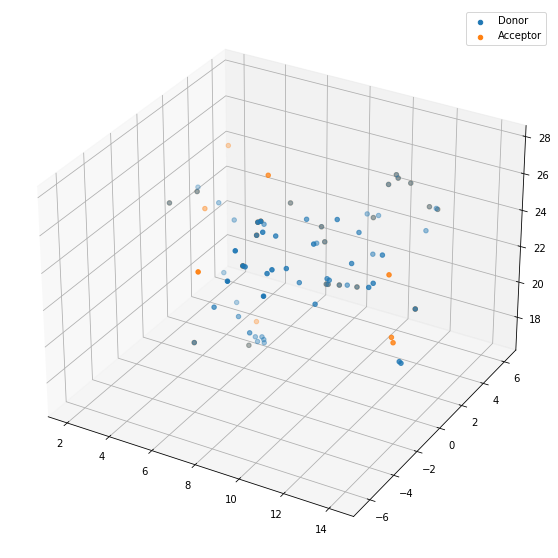

67
31


In [8]:
# run above functions
fragment_files, frag_filenames = get_sdfs('Mpro_fragments')
frag_mols = sdf_to_mol(fragment_files)
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)
plot_coords(frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords)

# NOTE ~20 fragments, number of ph4s will obvs be different
# like 67 donors, 31 acceptors
print(len(frag_donor_coords)) 
print(len(frag_acceptor_coords))


### Setting up fragment to align against fragments (test)

- set up ph4 fragment cloud like normal
- get ph4 points for one of the fragments
- transform those ph4 points
- map those points back to the cloud


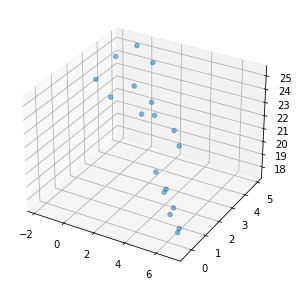

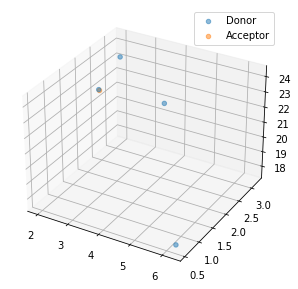

[[ 4.199  2.401 22.489]
 [ 6.244  0.543 17.664]
 [ 1.978  3.214 23.166]
 [ 3.015  1.422 24.221]
 [ 3.015  1.422 24.221]]
4
1


In [9]:
# just get first fragment in files
test_donor_coords, test_acceptor_coords, test_aromatic_coords = get_coords_query(frag_mols[0])
test_ph4_coords = np.concatenate([test_donor_coords, test_acceptor_coords])

# all coords of fragment (not just ph4s)
frag_test_mol_coords = frag_mols[0].GetConformer().GetPositions()

# plot
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(frag_test_mol_coords[:,0], frag_test_mol_coords[:,1], frag_test_mol_coords[:,2], alpha=0.5)
plt.show()

# plot ph4s
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(test_donor_coords[:,0], test_donor_coords[:,1], test_donor_coords[:,2], label='Donor', alpha=0.5)
ax.scatter3D(test_acceptor_coords[:,0], test_acceptor_coords[:,1], test_acceptor_coords[:,2], label='Acceptor', alpha=0.5)
plt.legend()
plt.show()

print(test_ph4_coords)
print(len(test_donor_coords))
print(len(test_acceptor_coords))

Transform coordinates of the fragment test molecule:

https://en.wikipedia.org/wiki/Rotation_matrix (scroll down for 'basic rotation')

In [10]:
def rot_ar_x(radi):
    return  np.array([[1, 0, 0], 
            [0, np.cos(radi), -np.sin(radi)], 
            [0, np.sin(radi), np.cos(radi)],], 
            dtype=np.double)

def rot_ar_y(radi):
    return  np.array([[np.cos(radi), 0, np.sin(radi)], 
            [0, 1, 0], 
            [-np.sin(radi), 0, np.cos(radi)],], 
            dtype=np.double)

def rot_ar_z(radi):
    return  np.array([[np.cos(radi), -np.sin(radi), 0], 
            [np.sin(radi), np.cos(radi), 0], 
            [0, 0, 1],], 
            dtype=np.double)

# transform fragment test ph4 coords by applying rotation matrices ? 
rot_matrix_x = rot_ar_x(np.pi)
rot_matrix_y = rot_ar_y(np.pi)
rot_matrix_z = rot_ar_y(np.pi)
rot_matrices = [rot_matrix_x, rot_matrix_y, rot_matrix_z]

test_points = test_ph4_coords@rot_matrix_x
test_points = test_points@rot_matrix_y
test_points = test_points@rot_matrix_z

print(test_ph4_coords)
print(test_points)

[[ 4.199  2.401 22.489]
 [ 6.244  0.543 17.664]
 [ 1.978  3.214 23.166]
 [ 3.015  1.422 24.221]
 [ 3.015  1.422 24.221]]
[[  4.199  -2.401 -22.489]
 [  6.244  -0.543 -17.664]
 [  1.978  -3.214 -23.166]
 [  3.015  -1.422 -24.221]
 [  3.015  -1.422 -24.221]]


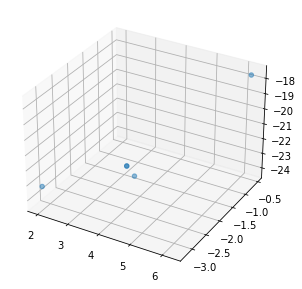

In [11]:
# plot to check transformed
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.scatter3D(test_points[:,0], test_points[:,1], test_points[:,2], alpha=0.5)
plt.show()

### Align transformed fragment back to fragment cloud 

- generate permutations of the relevant fragment points
- use code from most recent brute force draft (12/5/22)

In [12]:
import kabsch_functions_new as kabsch
import numpy as np
import scipy
import pandas as pd
import itertools


### Clustering

*unfinished*
- hierarchical clustering; use agglomerative clustering (sklearn)
- aim to reduce number of points in fragment point cloud if high density in particular areas
- 20 fragments with 98 points reduced to 36 clusters; if cluster also by ph4 type get 33 donor clusters and 18 acceptor clusters (no aromatic points)


https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/ - stuff on distance b/t clusters


In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
def cluster(data, distance_threshold):

    model = AgglomerativeClustering(linkage='average', n_clusters=None, distance_threshold=distance_threshold) # 0.5 - 1 
    model.fit_predict(data)
    pred = model.fit_predict(data)
    print("Number of clusters found: {}".format(len(set(model.labels_))))
    labels = model.labels_
    print('Cluster for each point: ', model.labels_)

    return labels


Find centroids of clusters: 

In [14]:
# function to get centroid of cluster of points:
# have put coords into dataframes because find it easier to access x/y/z coords rather than slicing arrays
# can use grouping in dataframes to more easily find centroids of clustered points

def get_centroids(df):

    x_means = df.groupby(['cluster_label'])['x'].mean()
    y_means = df.groupby(['cluster_label'])['y'].mean() 
    z_means = df.groupby(['cluster_label'])['z'].mean()

    cluster_centroids = []
    for x, y, z in zip(x_means, y_means, z_means):
        centroid_coords = [x, y, z]
        cluster_centroids.append(centroid_coords)

    return cluster_centroids

In [15]:
# cluster donor coords and add with labels to df
labels = cluster(frag_donor_coords, distance_threshold=1)
donor_df = pd.DataFrame([frag_donor_coords[:,0], frag_donor_coords[:,1], frag_donor_coords[:,2], labels])
donor_df = donor_df.transpose()
donor_df.columns = ['x', 'y', 'z', 'cluster_label']

# cluster acceptor coords and add with labels to df
labels = cluster(frag_acceptor_coords, distance_threshold=1)
acceptor_df = pd.DataFrame([frag_acceptor_coords[:,0], frag_acceptor_coords[:,1], frag_acceptor_coords[:,2], labels])
acceptor_df = acceptor_df.transpose()
acceptor_df.columns = ['x', 'y', 'z', 'cluster_label']



Number of clusters found: 46
Cluster for each point:  [45  3 25 38  5 31  6 24 10 36  8 14  7 30 28  2 39  9 23 34 44 27  3 43
 26 33  1 13 35  2  4  0  5  6 37 11  0  9 32  7 17  8 14 41 18 40 15 42
  3  7 14  8 16  3 22 29  1 30  4  3 12 10  0 19 21 20  5]
Number of clusters found: 23
Cluster for each point:  [ 1 16 21 10 13 12 15 22 20 11 19 14  2  4  0  4  1  5 17  3 10  2  9 10
  3 18  8 21  6  7  0]


In [16]:

# gives arrays of centroid coordinates for each cluster
donor_centroids = np.array(get_centroids(donor_df))
donor_centroid_df = pd.DataFrame([donor_centroids[:,0], donor_centroids[:,1], donor_centroids[:,2]]) # no cluster labels
donor_centroid_df = donor_centroid_df.transpose()
donor_centroid_df.columns = ['x', 'y', 'z']

acceptor_centroids = np.array(get_centroids(acceptor_df))
acceptor_centroid_df = pd.DataFrame([acceptor_centroids[:,0], acceptor_centroids[:,1], acceptor_centroids[:,2]]) # no cluster labels
acceptor_centroid_df = acceptor_centroid_df.transpose()
acceptor_centroid_df.columns = ['x', 'y', 'z']

# collect all points together as new pocket points
# create df with centroid points and labels for which ph4 type, so can separate back out different ph4 types later
# NOTE need to make this into function/more flexible
for row in donor_centroid_df.iterrows():
    donor_centroid_df['ph4_label'] = 'Donor'
for row in acceptor_centroid_df.iterrows():
    acceptor_centroid_df['ph4_label'] = 'Acceptor'

pocket_df = pd.concat([donor_centroid_df, acceptor_centroid_df]) 
print(pocket_df)

            x       y          z ph4_label
0    8.306667  2.3820  22.902667     Donor
1    8.898000 -5.2885  26.304000     Donor
2    8.283000 -2.0990  25.490000     Donor
3    6.549800  0.4448  17.680000     Donor
4   10.118000 -0.3380  22.752500     Donor
..        ...     ...        ...       ...
18   2.874000  4.2400  25.229000  Acceptor
19   9.210000 -5.5390  26.160000  Acceptor
20   5.753000  1.4990  17.784000  Acceptor
21   9.177000  1.3325  21.194500  Acceptor
22   9.293000 -4.2850  27.794000  Acceptor

[69 rows x 4 columns]



cluster pocket_points by distance:

- in this case for this one query molecule we only get one cluster because max distance is large, so number of permutations very high; have tested other molecules giving ~5 clusters which reduces number of permutations a lot



In [17]:
# cluster pocket_points by distance

# get max distance for pairwise points of query molecule
pdist_q = scipy.spatial.distance.pdist(test_points, metric='euclidean')
max_query_dist = np.max(pdist_q)
print(max_query_dist)

# get possible subpockets of fragment cloud by clustering, use query max dist as threshold

pocket_points = []
for x,y,z in zip(pocket_df['x'], pocket_df['y'], pocket_df['z']):
        # NOTE bug here, separation in donor/acceptor not adding up properly
        pocket_point = [x,y,z]
        pocket_points.append(pocket_point)
pocket_points = np.array(pocket_points)

cluster_labels = cluster(pocket_points, distance_threshold=max_query_dist) # order not lost ?? so use just points in clustering, then append list of labels to existing df with ph4 labels
pocket_df['cluster_label'] = pd.Series(cluster_labels) # NOTE should check this works ie stays in order/labels not wrong
print(pocket_df)





7.456876088550755
Number of clusters found: 2
Cluster for each point:  [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0]
            x       y          z ph4_label  cluster_label
0    8.306667  2.3820  22.902667     Donor              0
1    8.898000 -5.2885  26.304000     Donor              0
2    8.283000 -2.0990  25.490000     Donor              0
3    6.549800  0.4448  17.680000     Donor              1
4   10.118000 -0.3380  22.752500     Donor              0
..        ...     ...        ...       ...            ...
18   2.874000  4.2400  25.229000  Acceptor              0
19   9.210000 -5.5390  26.160000  Acceptor              0
20   5.753000  1.4990  17.784000  Acceptor              1
21   9.177000  1.3325  21.194500  Acceptor              0
22   9.293000 -4.2850  27.794000  Acceptor              1

[69 rows x 5 columns]


In [18]:
# sort back into ph4 types within main clusters (subpockets)
ph4_permutations = []

cluster_groups =  pocket_df.groupby('cluster_label')
for name, group in cluster_groups:
    # need to separate back into ph4 types
    # group within clusters by ph4 type
    ph4_types = group.groupby('ph4_label')
    # get arrays of point coords from each ph4 type
    donors = []
    acceptors = []
    for name, group in ph4_types:
        print(name, len(group))  # checked - gives totals of acceptors/donors expected
        for x,y,z in zip(group['x'], group['y'], group['z']):
            coords = [x,y,z]
            if name == 'Donor':
                donors.append(coords)
            elif name == 'Acceptor':
                acceptors.append(coords)

    # get possible combinations/permutations within subpocket, restricted by type/numbers of different ph4s in query molecule
    # e.g. first query mol has 4 donors, 1 acceptor, so from frag donor points choose 4, from acceptor points choose 1 (and then get permutations for different correspondences)
    for permutation in list(itertools.product(itertools.permutations(acceptors, len(test_acceptor_coords)), itertools.permutations(donors, len(test_donor_coords)))):
        ph4_permutations.append(permutation) 

print('PERMUTATIONS:', len(ph4_permutations)) # check number expected; 



Acceptor 17
Donor 33
Acceptor 6
Donor 13
PERMUTATIONS: 16798320


In [46]:
def kabsch_func(permutation, query_points):    
    # reformat coords for kabsch (N, 3)
    permutation = np.concatenate(permutation)

    qm_means = query_points.mean(0)
    frm_means = permutation.mean(0)
    qm_trans = query_points - qm_means
    frm_trans = permutation - frm_means

    trans_vector =  frm_means # add to revert_translation

    #For more speed use scipy.spatial.transform.Rotation.align_vectors. You still need to deal with translation
    rot_matrix, rmsd = scipy.spatial.transform.Rotation.align_vectors(a=frm_trans, b=qm_trans)
    rot_matrix = rot_matrix.as_matrix() # scipy gives Rotation object, get matrix

    # qm_reverted, frm_reverted = revert_translation(qm_rotated, frm_trans, qm_means, frm_means)
    qm_rotated = qm_trans@rot_matrix
    qm_aligned =  qm_rotated + trans_vector
    rmsd_val = kabsch.rmsd(qm_aligned, frm_trans + trans_vector)

    return rmsd_val, qm_aligned, permutation

debugging function

In [41]:
kabsch_func(ph4_permutations[0], test_points)

[[ 0.57204325  0.72267247  0.3879575 ]
 [ 0.51958727  0.04670933 -0.85313967]
 [-0.63466179  0.68961057 -0.34877166]]


(5.013982143390722,
 array([[ 9.67213132, -0.3241119 , 23.42251846],
        [12.93880975, -2.26040363, 27.48384834],
        [ 8.39438169, -1.42432641, 21.63114387],
        [ 7.38692195, -0.03107903, 23.194328  ],
        [ 7.38692195, -0.03107903, 23.194328  ]]),
 array([[10.1735    ,  1.2725    , 21.477     ],
        [ 8.30666667,  2.382     , 22.90266667],
        [ 8.898     , -5.2885    , 26.304     ],
        [ 8.283     , -2.099     , 25.49      ],
        [10.118     , -0.338     , 22.7525    ]]))

test without transforming test points

In [43]:
test_points = np.concatenate([test_donor_coords, test_acceptor_coords])

print(test_points)

[[ 4.199  2.401 22.489]
 [ 6.244  0.543 17.664]
 [ 1.978  3.214 23.166]
 [ 3.015  1.422 24.221]
 [ 3.015  1.422 24.221]]


In [47]:
import joblib
from joblib import Parallel, delayed

# NOTE but want to do this instead, exactly the same but running parallel

# create df to hold results
results_df = pd.DataFrame()
rmsd_vals = []
permutations = [] 
qm_aligned_all = []

results = Parallel(n_jobs=2)(delayed(kabsch_func)(permutation=permutation, query_points=test_points) for permutation in ph4_permutations)
for result in results:
    rmsd_vals.append(result[0])
    qm_aligned_all.append(result[1])
    permutations.append(result[2])

In [48]:
print(rmsd_vals[0:10])

[5.013982143390722, 5.200550139801678, 4.04134391259595, 4.213463354031962, 5.278229288479111, 6.230467454786479, 4.718894740800732, 2.697625551018195, 2.5432005860075186, 4.401835817733232]


In [49]:
results_df['RMSD'] = pd.Series(rmsd_vals)
results_df['Fragment'] = pd.Series(permutations)
results_df['Query'] = pd.Series(qm_aligned_all)

Get best result/s:



            RMSD                                           Fragment  \
913364  0.842485  [[10.1735, 1.2725, 21.476999999999997], [10.50...   
913713  0.842485  [[10.1735, 1.2725, 21.476999999999997], [10.50...   

                                                    Query  
913364  [[10.197534702658004, 1.0316496465708542, 21.9...  
913713  [[10.197534702658004, 1.0316496465708542, 21.9...  
[[10.1975347   1.03164965 21.99834812]
 [10.54088996  6.07305628 24.31807663]
 [11.39392319 -1.08098349 22.3953051 ]
 [ 9.08057607 -0.92111122 22.54538507]
 [ 9.08057607 -0.92111122 22.54538507]]
[[10.1975347   1.03164965 21.99834812]
 [10.54088996  6.07305628 24.31807663]
 [11.39392319 -1.08098349 22.3953051 ]
 [ 9.08057607 -0.92111122 22.54538507]
 [ 9.08057607 -0.92111122 22.54538507]]


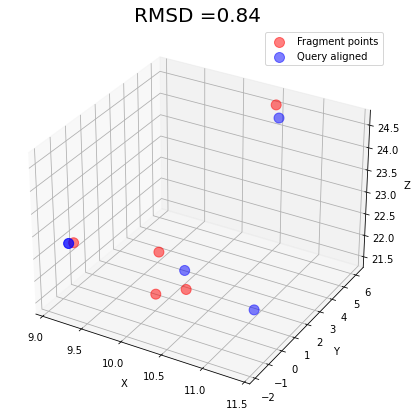

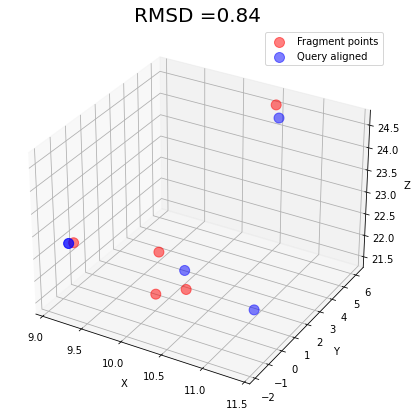

In [50]:
# get row of df with lowest RMSD to get fragment and query points
best_results = results_df.loc[results_df['RMSD'] == np.min(results_df['RMSD'])]
best_results = pd.DataFrame(best_results, columns=['RMSD', 'Fragment', 'Query'])

print(best_results)

for result in best_results.itertuples(index=False):

    # plot best result/s (sometimes multiple with same RMSD)
    ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
    # plot matrices for comparison 
    print(result[2])
    ax.scatter3D(result[1][:,0], result[1][:,1], result[1][:,2], label='Fragment points', color='r', s=100, alpha=0.5)
    ax.scatter3D(result[2][:,0], result[2][:,1], result[2][:,2], label='Query aligned', color='b', s=100, alpha=0.5)
    # set plot titles and labels
    ax.legend(loc='upper right')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    plt.title(str('RMSD =' + str("{:.2f}".format(float(result[0])))), fontsize=20)


*test* aligning a fragment back to fragment cloud even without transforming the test points does not give rmsd=0

--> check actual points returned:


In [51]:
# print original fragment used as query
print('ORIGINAL FRAGMENT (query) POINTS:', test_points)

# print fragment points found in cloud for best alignment
print('FRAGMENT POINTS FOUND IN CLOUD:', np.array(best_results['Fragment']))

# print fragment aligned points
print('FRAGMENT (query) POINTS ALIGNED:', np.array(best_results['Query']))

ORIGINAL FRAGMENT (query) POINTS: [[ 4.199  2.401 22.489]
 [ 6.244  0.543 17.664]
 [ 1.978  3.214 23.166]
 [ 3.015  1.422 24.221]
 [ 3.015  1.422 24.221]]
FRAGMENT POINTS FOUND IN CLOUD: [array([[10.1735,  1.2725, 21.477 ],
        [10.507 ,  6.044 , 24.601 ],
        [10.339 , -1.822 , 22.355 ],
        [10.118 , -0.338 , 22.7525],
        [ 9.156 , -0.975 , 22.617 ]]) array([[10.1735,  1.2725, 21.477 ],
                                             [10.507 ,  6.044 , 24.601 ],
                                             [10.339 , -1.822 , 22.355 ],
                                             [ 9.156 , -0.975 , 22.617 ],
                                             [10.118 , -0.338 , 22.7525]])]
FRAGMENT (query) POINTS ALIGNED: [array([[10.1975347 ,  1.03164965, 21.99834812],
        [10.54088996,  6.07305628, 24.31807663],
        [11.39392319, -1.08098349, 22.3953051 ],
        [ 9.08057607, -0.92111122, 22.54538507],
        [ 9.08057607, -0.92111122, 22.54538507]])
 array([[10.19

In [52]:
print('minimum:', np.min(rmsd_vals))
print('minimum df:', np.min(results_df['RMSD']))

print('maximum:', np.max(rmsd_vals))
print('maximum df:', np.max(results_df['RMSD']))

print('mean:', np.mean(rmsd_vals))
print('mean:', np.mean(results_df['RMSD']))

minimum: 0.842485242190043
minimum df: 0.842485242190043
maximum: 8.949066937383837
maximum df: 8.949066937383837
mean: 4.545949002033749
mean: 4.545949002033749


plot where query (test fragment) points map to before alignment compared to where they end up after alignment

- know that they do overlap with fragment points to start with
- think that they are not mapping back to their own fragment ph4 points in the cloud 

BEFORE:

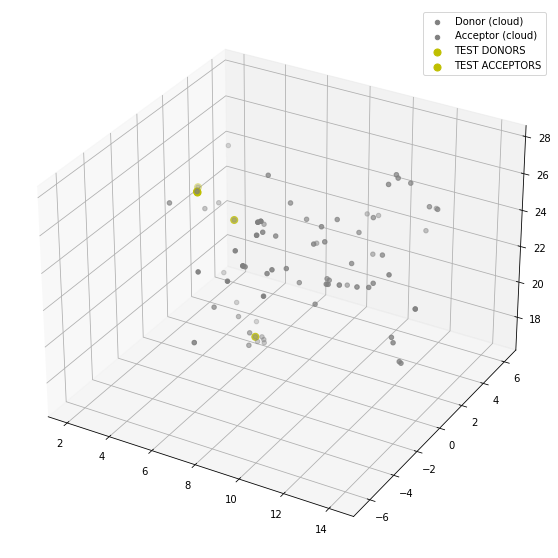

In [76]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
labels = ['Donor (cloud)', 'Acceptor (cloud)', 'Aromatic']
for coords, label in zip([frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords], labels):
    if len(coords) != 0:
        ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label, c='grey')
ax.scatter3D(test_donor_coords[:,0], test_donor_coords[:,1], test_donor_coords[:,2], label='TEST DONORS', c='y', s=50)
ax.scatter3D(test_acceptor_coords[:,0], test_acceptor_coords[:,1], test_acceptor_coords[:,2], label='TEST ACCEPTORS', c='y', s=50)
plt.legend()
plt.show()

AFTER:

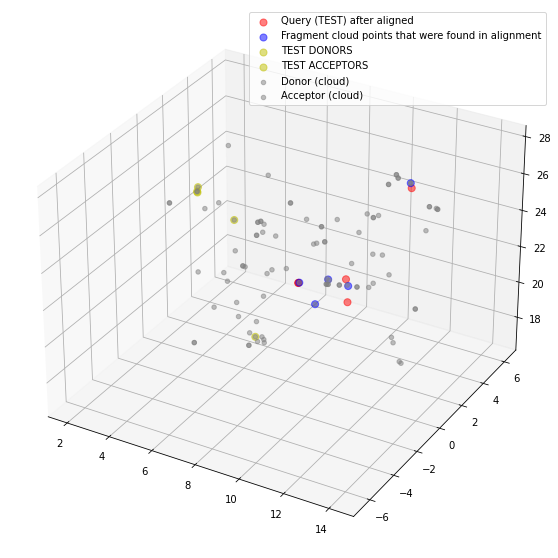

In [74]:
# run above functions
fragment_files, frag_filenames = get_sdfs('Mpro_fragments')
frag_mols = sdf_to_mol(fragment_files)
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)


test_donor_coords, test_acceptor_coords, test_aromatic_coords = get_coords_query(frag_mols[0])

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

query_points = np.array(best_results['Query'])
query_points = query_points[0]

cloud_points_found = np.array(best_results['Fragment'])
cloud_points_found = cloud_points_found[0]

labels = ['Donor (cloud)', 'Acceptor (cloud)', 'Aromatic']
# plot points
# fragment test query results (After alignment)
ax.scatter3D(query_points[:,0], query_points[:,1], query_points[:,2], label='Query (TEST) after aligned', c='r', s=50, alpha=0.5)
# cloud fragment points found in alignment
ax.scatter3D(cloud_points_found[:,0], cloud_points_found[:,1], cloud_points_found[:,2], label='Fragment cloud points that were found in alignment', c='b', s=50, alpha=0.5)
# original test points before alignment
ax.scatter3D(test_donor_coords[:,0], test_donor_coords[:,1], test_donor_coords[:,2], label='TEST DONORS', c='y', s=50, alpha=0.5)
ax.scatter3D(test_acceptor_coords[:,0], test_acceptor_coords[:,1], test_acceptor_coords[:,2], label='TEST ACCEPTORS', c='y', s=50, alpha=0.5)
# all fragment cloud points
labels = ['Donor (cloud)', 'Acceptor (cloud)', 'Aromatic (cloud']
for coords, label in zip([frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords], labels):
    if len(coords) != 0:
        ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label, alpha=0.5, c='grey')

plt.legend()
plt.show()